In [11]:
#import libraries
import numpy as np
import pprint
import scipy
import scipy.linalg
import pandas as pd
import random
import csv
import gzip
import seaborn as sns
from collections import OrderedDict
from scipy.linalg import svd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json
from tqdm import tqdm
from collections import defaultdict
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, KNNBasic, KNNBaseline, KNNWithMeans, BaselineOnly
from surprise.model_selection import train_test_split
np.set_printoptions(threshold=20)
pd.options.mode.copy_on_write = True
from ipynb.fs.full.SVD_FUNCTIONS import csv_to_df
from ipynb.fs.full.SVD_FUNCTIONS import Convert_to_Matrix
from ipynb.fs.full.SVD_FUNCTIONS import LU_Factorization
from ipynb.fs.full.SVD_FUNCTIONS import find_similar
from ipynb.fs.full.SVD_FUNCTIONS import get_most_frequent_users
from ipynb.fs.full.SVD_FUNCTIONS import get_users_with_minimal_ratings
from ipynb.fs.full.SVD_FUNCTIONS import get_training_data
from ipynb.fs.full.SVD_FUNCTIONS import pivot_rating_to_user_frame
from ipynb.fs.full.SVD_FUNCTIONS import do_svd
from ipynb.fs.full.SVD_FUNCTIONS import plot_data

from ipynb.fs.full.SVD_FUNCTIONS import recommend
from ipynb.fs.full.SVD_FUNCTIONS import get_tier_list
from ipynb.fs.full.SVD_FUNCTIONS import get_individual_user_data
from ipynb.fs.full.SVD_FUNCTIONS import print_user_data


In [12]:
#Gets User Id from training set
def get_Iu(uid):

    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
        
#Gets Item Id from training set    
def get_Ui(iid):

    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    

In [13]:
books_ratings_cleaned, book_dict = csv_to_df("Books_rating.csv", "books_data.csv")

In [14]:
df = pd.read_csv('ratings_user_tagged.csv.gzip', compression='gzip')
drop_column = ["Unnamed: 0"]
df_cleaned = df.drop(drop_column, axis=1)
columns_titles = ["User_id","book_id", "review/score"]
svd_columns_titles = ["book_id","User_id","review/score"]
df_cleaned = df_cleaned.reindex(columns=columns_titles)
df_svd_cleaned = df_cleaned.reindex(columns=svd_columns_titles)
df_cleaned.head()

,User_id,book_id,review/score
0,A30TK6U7DNS82R,0826414346,5.0
1,A2MVUWT453QH61,0826414346,4.0
2,A2F6NONFUDB6UK,0826414346,4.0
3,A14OJS0VWMOSWO,0826414346,5.0
4,A373VVEU6Z9M0N,0829814000,5.0


In [15]:
len(df_cleaned['book_id'].unique())

92327

In [16]:
len(df_cleaned['User_id'].unique())

6842

In [17]:
USERBOOK = df_cleaned

reader = Reader()
data = Dataset.load_from_df(USERBOOK, reader)

In [43]:
algo = SVD(n_factors= 100, n_epochs = 200, biased= True, lr_all= 0.005, reg_all= 0.005, init_mean= 0, init_std_dev= 0.01)
algo_pp = SVD(n_factors= 100, n_epochs = 200, biased= True, lr_all= 0.005, reg_all= 0.005, init_mean= 0, init_std_dev= 0.01)
algo_no_bias = SVD(n_factors= 100, n_epochs = 200, biased= False)

In [19]:
#Run SVD Algorithm
# Run 5-fold cross-validation and print results.
#cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

In [20]:
trainset, testset = train_test_split(data, test_size=0.20)
algo.fit(trainset)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)


RMSE: 0.7691


0.7690916620825213

In [44]:
trainset, testset = train_test_split(data, test_size=0.20)
algo_no_bias.fit(trainset)
predictions = algo_no_bias.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 1.3275


1.3274664213614251

In [ ]:
#For testing Loss vs Epoch!

epoch_data = []
num = 1

for i in range(0,200):
    algo = SVD(n_factors= 100, n_epochs = num, biased= True, lr_all= 0.005, reg_all= 0.005, init_mean= 0, init_std_dev= 0.01)
    trainset, testset = train_test_split(data, test_size=0.20)
    algo.fit(trainset)
    predictions = algo.fit(trainset).test(testset)
    num += 1
    #accuracy.rmse(predictions)
    epoch_data.append(accuracy.rmse(predictions))

In [ ]:
#Print out epoch_data to be plotted in Loss vs Epoch chart
#epoch_data

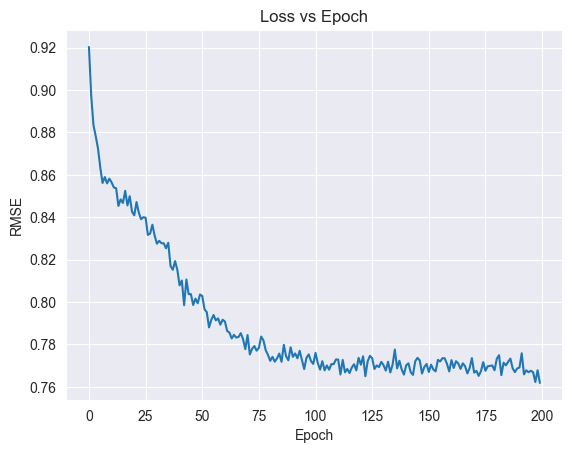

In [53]:
#Plot data for loss vs epoch
#To produce the list epoch_data, 
#it'll take about an hour to run the data above to track the epochs for SGD

sns.set_style("darkgrid")
plt.plot(epoch_data)
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

In [21]:
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [22]:
rand_predictions = []
for i in range(0,10):
    rand_predictions.append(random.choice(predictions))

rand_predictions


[Prediction(uid='A3FDBBQ0NK2SSO', iid='0786868430', r_ui=5.0, est=4.005223842843167, details={'was_impossible': False}),
 Prediction(uid='A3SQQYS79AV13M', iid='B00070YG7G', r_ui=5.0, est=5, details={'was_impossible': False}),
 Prediction(uid='A3R1D7LZUJ2H6H', iid='B000NPAT6W', r_ui=5.0, est=5, details={'was_impossible': False}),
 Prediction(uid='ASXG52A51ERM', iid='0789496356', r_ui=3.0, est=3.0669204171033213, details={'was_impossible': False}),
 Prediction(uid='A34QGZBQIG3U0E', iid='B000E7YO8S', r_ui=5.0, est=3.0266369068365173, details={'was_impossible': False}),
 Prediction(uid='A1DYXCF4148PJT', iid='B000FMIPPA', r_ui=4.0, est=4.337268768957792, details={'was_impossible': False}),
 Prediction(uid='A2HM0BZWQRV1EF', iid='B000GRSAAO', r_ui=5.0, est=4.325600152789545, details={'was_impossible': False}),
 Prediction(uid='A3U4CXG2SM0497', iid='0671700030', r_ui=5.0, est=4.4688631789284115, details={'was_impossible': False}),
 Prediction(uid='A2VE83MZF98ITY', iid='080850861X', r_ui=5.0, e

In [23]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
9936,A1G9FX1KV45N41,B000N28H2I,5.0,5.0,{'was_impossible': False},280,153,0.0
5419,A2ZFOF8BYA5RD7,0395051029,5.0,5.0,{'was_impossible': False},14,223,0.0
73582,A18OBUSMXVE8R0,0689823959,5.0,5.0,{'was_impossible': False},219,7,0.0
23388,A1200KY1P1CPMD,9992952709,5.0,5.0,{'was_impossible': False},20,2,0.0
5416,A2OJW07GQRNJUT,0520224655,5.0,5.0,{'was_impossible': False},754,6,0.0
14253,AK84ZKCW4FY6N,B000GTECHM,5.0,5.0,{'was_impossible': False},19,17,0.0
5413,A3F1G6UH4Y39X2,B000OY6A74,5.0,5.0,{'was_impossible': False},61,12,0.0
48361,A2XA6MEIKHNJ17,0446613827,5.0,5.0,{'was_impossible': False},24,6,0.0
48372,A15J07RXB3W0YX,0553289713,5.0,5.0,{'was_impossible': False},72,183,0.0
61016,A1RPTVW5VEOSI,B000PX5UZC,5.0,5.0,{'was_impossible': False},111,153,0.0


In [24]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
67863,A37XGUQ1VH0XM6,1561705357,1.0,5.0,{'was_impossible': False},333,1,4.0
79744,A321W4SSC0F6AP,1570424713,1.0,5.0,{'was_impossible': False},40,14,4.0
48371,A2Z9XBCYT3AHHU,B000L6Q9ZS,1.0,5.0,{'was_impossible': False},59,115,4.0
19665,A2B69DXYJTGTHY,1595550046,1.0,5.0,{'was_impossible': False},17,2,4.0
37939,A3EJT905S6ZS4K,0939482010,1.0,5.0,{'was_impossible': False},98,1,4.0
28559,A3H3IC2SOP8OHT,0816148015,1.0,5.0,{'was_impossible': False},31,48,4.0
22388,A1XN6MBYDBTX16,B0007DLN6K,1.0,5.0,{'was_impossible': False},63,22,4.0
15940,A250BI36M1IR26,141591673X,1.0,5.0,{'was_impossible': False},97,41,4.0
19443,A2X3E8EU2KBVN8,1400101719,1.0,5.0,{'was_impossible': False},14,7,4.0
44152,A1CQJZSI3LK1VS,B000O3Q0SY,1.0,5.0,{'was_impossible': False},18,67,4.0


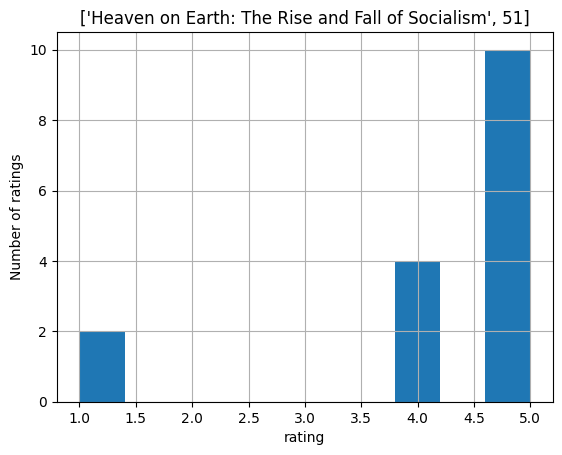

In [25]:
%matplotlib inline
var = 'B000HOMU2U'
df_cleaned.loc[df_cleaned['book_id'] == var]['review/score'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title(book_dict.get(var))
plt.show()

In [26]:
#dataset = data.build_full_trainset()
#svd = SVD(n_factors=10, reg_all=0.02)
#svd.fit(dataset)

In [27]:
def get_top_n(predictions, n):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
            user_ratings.sort(key=lambda x: x[1], reverse=True)
            top_n[uid] = user_ratings[:n]
    return top_n

In [28]:
top_n = get_top_n(predictions, n=5)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A2VKWLCNZF4ZVB ['0767908392', 'B000OWNRUY', '0786248645', '0786238704', '0060099526']
AT3ESUWYNLKUK ['1559350334', 'B000FTS0K8', 'B000GQG5MA', 'B000N28H2I', '0553804677']
A2N3YAM4K3ATM ['B000I1V604', 'B000I1VJLA', 'B000PIIMPW', 'B000FTCJIW', 'B00085ZYCQ']
A3VNV65XYKKY6A ['B000056MLJ', 'B000QEED1M', '1580495974', 'B000PCESRE', '0743477375']
A2THU56YB588IA ['B0007DRGI4', '0606300023', '1883010594', '0515120626', '0736649948']
A1D2C0WDCSHUWZ ['B000N28H2I', 'B00086Q2XK', 'B000733JY4', 'B00086Q2XK', '0613176375']
A3C0380R9NMLHD ['B000JJVHZE', '0816147736', '141761806X', '0003300277', 'B000NXL35A']
A16QQ78I8J29PA ['B000MWC38S', '0613707060', '0786862882', '0385334338', 'B000MWF97K']
A2SUDR7YAI2ZQA ['B000G2OZ62', 'B0007AFO7M', 'B000JGTOA2', 'B000MS0A0K', '0974304824']
AFYYHRPSFBLWS ['0140860428', 'B000TZ19TC', 'B0006ADVPU', 'B000LALMWO', 'B000PW9W66']
A89ZZKNDFQH23 ['B000NYRZ42', 'B000NDSX6C', '9626341823', 'B0006DH7WU', '0743477375']
A3O2RCKAMSE9X7 ['0451519418', '0671415247', '1561799157', 

In [ ]:
predict_list = ['A2VE83MZF98ITY','142331073X', 'B0006YH0R6', '0896211150', '0871401525', 'B0006BYOT6']
print('Predictions for User:', predict_list[0])
for i in range(1,6):
    print(book_dict.get(predict_list[i]))

In [ ]:
predict_list = ['A1JH5J1KQAUBMP', 'B0006AQG7U', 'B000NR8BAG', 'B000IOHQKA', '0613706633', '0808510258']
print('Predictions for User:', predict_list[0])
for i in range(1,6):
    print(book_dict.get(predict_list[i]))

In [ ]:
prediction_list = []

for i in range(len(predictions)):
    prediction_list.append(predictions[i])

prediction_list

In [32]:
prediction_array = np.asarray(prediction_list)
prediction_array = np.delete(prediction_array, 4, 1)
prediction_array

array([['A2VKWLCNZF4ZVB', '1593372051', 4.0, 3.928100318069623],
       ['AT3ESUWYNLKUK', '0670836850', 3.0, 3.44417056943003],
       ['A2N3YAM4K3ATM', '0816157871', 3.0, 3.978751647069022],
       ...,
       ['A3EYEZ5NH2HFFY', '0440204291', 4.0, 3.044290779370746],
       ['AT2R7ZVT7QYOU', 'B0007J6PZI', 5.0, 4.353589089146402],
       ['A3DFKHXFBUTL30', 'B0007DLKUO', 5.0, 4.756781563712732]],
      dtype=object)

In [33]:
with open('predictions.csv', "w") as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        for line in prediction_array:
            writer.writerow(line)

In [34]:
book_dict.get('B000MUBERQ')

['The Turkish Language Reform: A Catastrophic Success (Oxford Linguistics)', 8]

In [35]:
# Reconstruction of original matrix
#original = np.zeros((trainset.n_users, trainset.n_items))
#for (u, i, r) in trainset.all_ratings():
#    original[u][i] = r

# Plot matrix
#fig, ax = plt.subplots(figsize=(10, 10))
#sns.heatmap(original, ax=ax)
#ax.set_title("Original Matrix", fontsize = 16)
#ax.set_xlabel('item', fontsize = 12)
#ax.set_ylabel('user', fontsize = 12)
#plt.show()

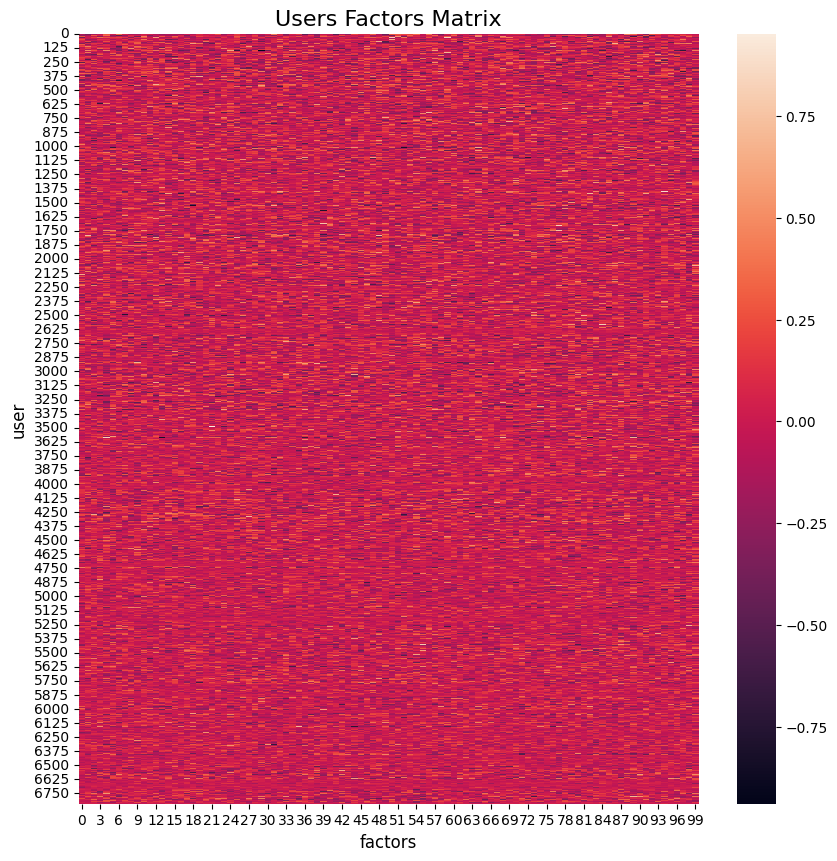

In [36]:
# Users factors matrix with 5 factors
pu = algo.pu

# Plot users factors
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(pu, ax=ax)
ax.set_title("Users Factors Matrix", fontsize = 16)
ax.set_xlabel('factors', fontsize = 12)
ax.set_ylabel('user', fontsize = 12)
plt.show()

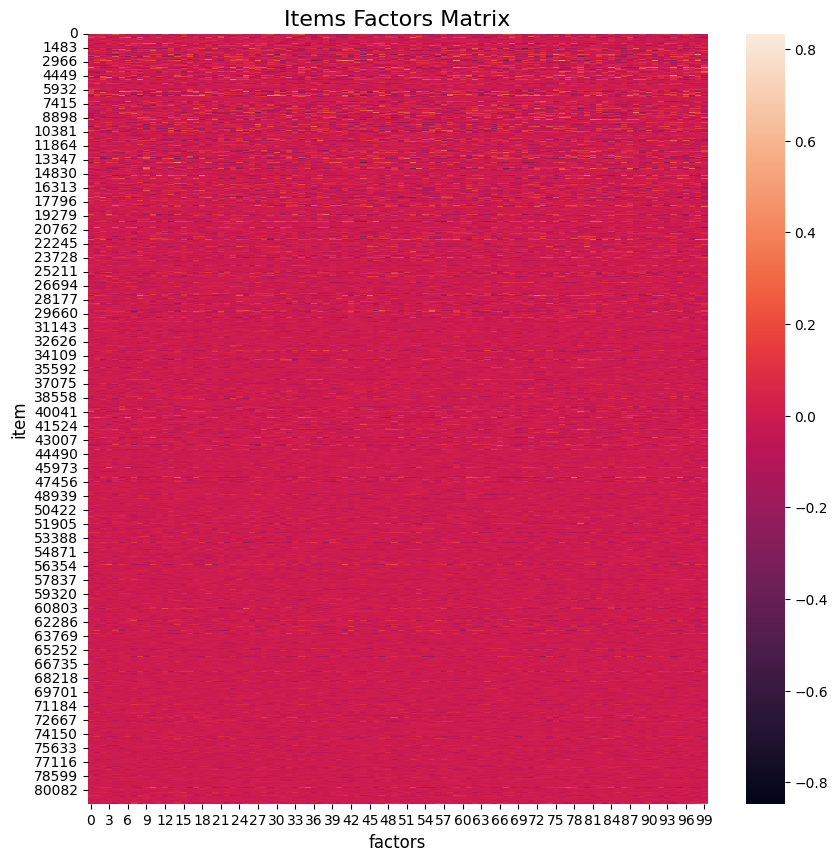

In [37]:
# Items factors matrix with 5 factors
qi = algo.qi

# Plot items factors
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(qi, ax=ax)
ax.set_title("Items Factors Matrix", fontsize = 16)
ax.set_xlabel('factors', fontsize = 12)
ax.set_ylabel('item', fontsize = 12)
plt.show()

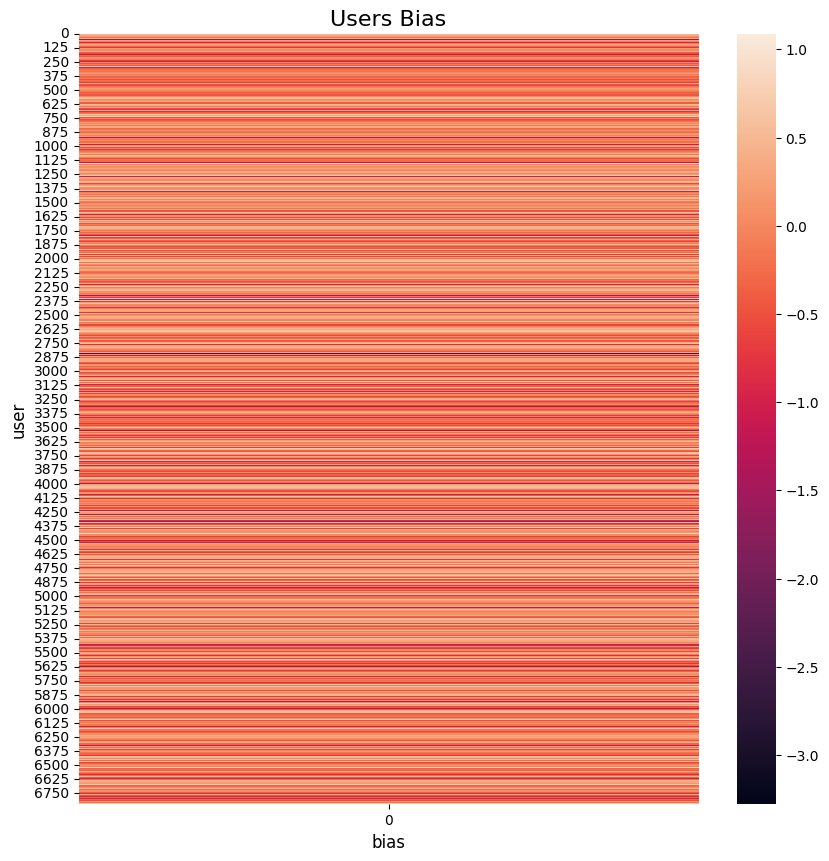

In [38]:
# Users bias
bu = algo.bu.reshape(algo.bu.shape[0], 1)

# Plot bias
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(bu, ax=ax)
ax.set_title("Users Bias", fontsize = 16)
ax.set_xlabel('bias', fontsize = 12)
ax.set_ylabel('user', fontsize = 12)
plt.show()

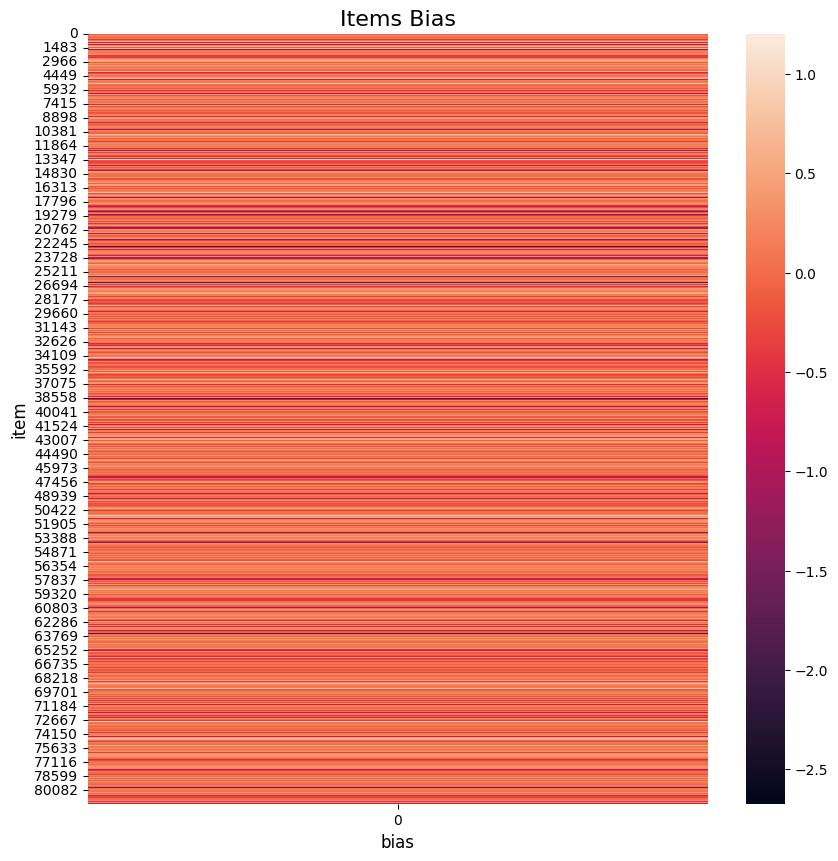

In [39]:
# Items bias
bi = algo.bi.reshape(algo.bi.shape[0], 1)

# Plot bias
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(bi, ax=ax)
ax.set_title("Items Bias", fontsize = 16)
ax.set_xlabel('bias', fontsize = 12)
ax.set_ylabel('item', fontsize = 12)
plt.show()

In [40]:
np.linalg.matrix_rank(qi)

100

In [41]:
trainset, testset = train_test_split(data, test_size=0.20)
algo_pp.fit(trainset)
predictions = algo_pp.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.7664


0.7664220457537912

NameError: name 'test_time' is not defined